# Import necessary libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import ReLU, Add, Input, SpatialDropout2D, GlobalMaxPooling2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
clear_session()

# Function to copy a limited number of images for training and validation

In [3]:
def create_limited_dataset(real_folder, fake_folder, output_folder, limit=5000):
    real_output = os.path.join(output_folder, 'real')
    fake_output = os.path.join(output_folder, 'fake')

    os.makedirs(real_output, exist_ok=True)
    os.makedirs(fake_output, exist_ok=True)

    for idx, img_name in enumerate(os.listdir(real_folder)[:limit]):
        shutil.copy(os.path.join(real_folder, img_name), os.path.join(real_output, img_name))

    for idx, img_name in enumerate(os.listdir(fake_folder)[:limit]):
        shutil.copy(os.path.join(fake_folder, img_name), os.path.join(fake_output, img_name))

    return real_output, fake_output

real_folder = r"C:\Users\Shreya Jadhav\Documents\B.Tech7\Project-III\Training\dataset_set\Test\Real"
fake_folder = r"C:\Users\Shreya Jadhav\Documents\B.Tech7\Project-III\Training\dataset_set\Test\Fake"

output_folder = r"C:\Users\Shreya Jadhav\Documents\B.Tech7\Project-III\Training\op"
limited_real_folder, limited_fake_folder = create_limited_dataset(real_folder, fake_folder, output_folder)

# Function to load and preprocess data

In [4]:
def load_and_preprocess_data(base_folder, img_size=(128, 128), batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        validation_split=0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    
    train_data_gen = datagen.flow_from_directory(
        base_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )
    
    val_data_gen = datagen.flow_from_directory(
        base_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )
    
    return train_data_gen, val_data_gen

base_folder = r"C:\\Users\\Shreya Jadhav\\Documents\\B.Tech7\\Project-III\\Training\\op"

train_data, val_data = load_and_preprocess_data(base_folder)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Model architecture

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

C:\Users\Shreya Jadhav\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

# ModelCheckpoint callback and training

In [6]:
checkpoint_filepath = 'keras_5k_model_93.keras'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history = model.fit(
    train_data,
    epochs=25,
    validation_data=val_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[checkpoint_callback]
)

Epoch 1/25


C:\Users\Shreya Jadhav\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.5151 - loss: 0.7608
Epoch 1: val_accuracy improved from -inf to 0.50353, saving model to pytorch_5k_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 192s 737ms/step - accuracy: 0.5151 - loss: 0.7608 - val_accuracy: 0.5035 - val_loss: 0.6961
Epoch 2/25

Epoch 2: val_accuracy improved from 0.50353 to 0.75000, saving model to pytorch_5k_model.keras


C:\Users\Shreya Jadhav\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.6237
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.5385 - loss: 0.7269
Epoch 3: val_accuracy did not improve from 0.75000
250/250 ━━━━━━━━━━━━━━━━━━━━ 104s 410ms/step - accuracy: 0.5385 - loss: 0.7269 - val_accuracy: 0.5323 - val_loss: 0.7054
Epoch 4/25

Epoch 4: val_accuracy did not improve from 0.75000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.6675
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.5461 - loss: 0.7196
Epoch 5: val_accuracy did not improve from 0.75000
250/250 ━━━━━━━━━━━━━━━━━━━━ 112s 442ms/step - accuracy: 0.5462 - loss: 0.7196 - val_accuracy: 0.5146 - val_loss: 0.7221
Epoch 6/25

Epoch 6: val_accuracy did not improve from 0.75000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy:

# Load the trained model

In [6]:
model = load_model('keras_5k_model_93.keras')
print("Model loaded successfully!")

Model loaded successfully!


# Function for prediction

In [7]:
def detect_deepfake(image_path, model, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0 
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0] 

    # Display the image
    plt.imshow(load_img(image_path)) 
    plt.axis('off') 
    plt.title(f"Prediction: {'Fake' if prediction > 0.5 else 'Real'}")
    plt.show()

    return "Fake" if prediction > 0.5 else "Real"

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


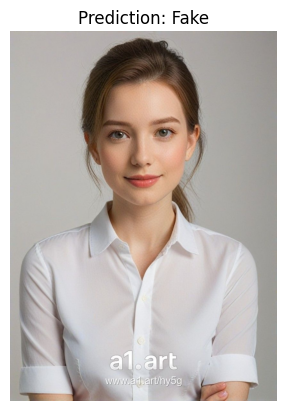

The input image is classified as: Fake


In [8]:
# Example usage
test_image_path = r"C:\Users\Shreya Jadhav\Pictures\ID_photo.jpeg"  # Replace with the path to your test image
result = detect_deepfake(test_image_path, model)
print(f"The input image is classified as: {result}")